<a href="https://colab.research.google.com/github/miraclehimself/Advanced_ML/blob/main/Automated_Feature_Selection_week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AML 22-23 S2W5 Lecture: Automated Feature Selection

* Why feature selection?
    - Simplicity
    - Try to avoid overfitting
    - Try to avoid multicollinearity
    - Uninformative features might hurt some models (more than others)
    - Train/predict performance

## Packages

In [ ]:
!pip install --upgrade scikit-learn -q --user
# need to restart kernel, if latest versions not already installed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 78.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set(
    style='ticks',
    context='talk',
    font_scale=0.8,
    rc={'figure.figsize': (8,6)}
)

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [ ]:
from sklearn.metrics import mean_squared_error
from functools import partial
rmse = partial(mean_squared_error, squared=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
from sklearn.datasets import make_regression

## Case Study: Synthetic Dataset

### Making the Regression Dataset

The technicalities here are not the today's topic. The important message is that we ask sklearn to create a synthetic dataset with 200 samples, 10 features, 7 of which being informative, for a quantitative target (regression).

In [ ]:
X, y = make_regression(
    n_samples=200,
    n_features=10,
    n_informative=7,
    noise=0.2,
    effective_rank=7,
    random_state=42
)

In [ ]:
X = pd.DataFrame(X).rename(columns=lambda x: 'x' + str(x))
X.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,-0.067129,-0.050331,0.001934,0.064676,-0.010691,-0.007337,-0.029875,-0.057434,-0.070257,0.019514
1,0.024038,-0.151941,-0.011122,0.072388,0.049998,0.014092,0.141541,0.119834,0.059714,-0.046511
2,0.028244,0.006726,0.017242,0.091272,0.009618,0.090522,0.065806,0.042542,0.114960,-0.025738
3,0.000540,0.111140,-0.001892,-0.042694,0.047279,-0.113926,0.001695,-0.018666,-0.039486,-0.032984
4,0.019776,-0.038470,-0.052773,0.104961,0.072323,-0.039911,0.043904,-0.052150,-0.131623,0.013012


In [ ]:
y = pd.Series(y).rename('target')
y.head()

0   -10.860442
1    11.301952
2    18.558125
3     4.060078
4     2.582899
Name: target, dtype: float64

In [ ]:
data = pd.concat([X,y], axis='columns')
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,target
0,-0.067129,-0.050331,0.001934,0.064676,-0.010691,-0.007337,-0.029875,-0.057434,-0.070257,0.019514,-10.860442
1,0.024038,-0.151941,-0.011122,0.072388,0.049998,0.014092,0.141541,0.119834,0.059714,-0.046511,11.301952
2,0.028244,0.006726,0.017242,0.091272,0.009618,0.090522,0.065806,0.042542,0.114960,-0.025738,18.558125
3,0.000540,0.111140,-0.001892,-0.042694,0.047279,-0.113926,0.001695,-0.018666,-0.039486,-0.032984,4.060078
4,0.019776,-0.038470,-0.052773,0.104961,0.072323,-0.039911,0.043904,-0.052150,-0.131623,0.013012,2.582899


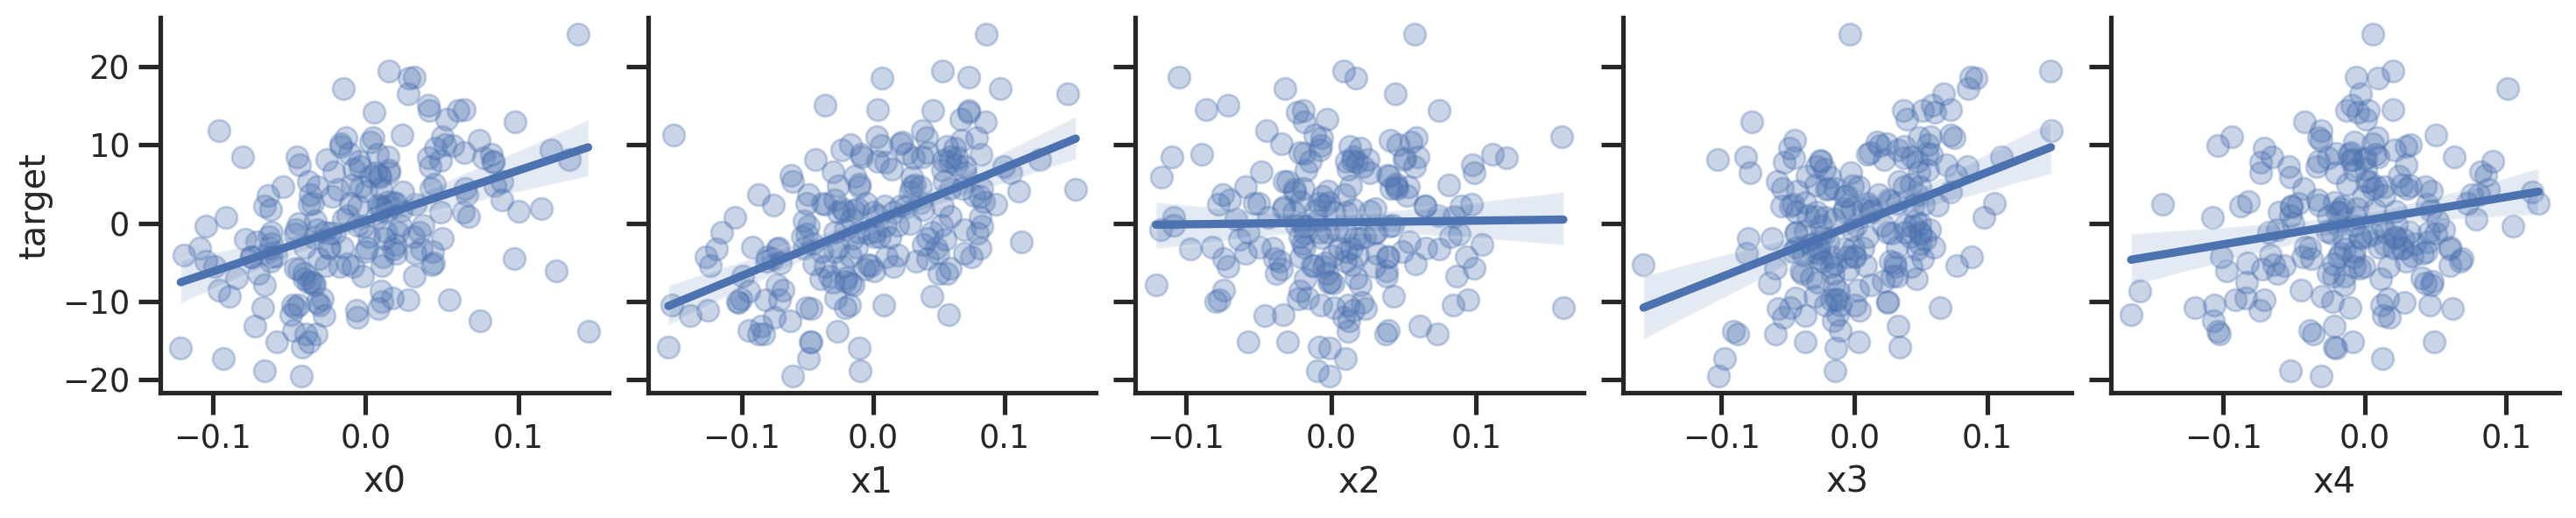

In [ ]:
sns.pairplot(
    data=data, x_vars=['x0','x1','x2','x3','x4'], y_vars='target',
    height=3, kind='reg', plot_kws=dict(scatter_kws=(dict(alpha=0.3)))
);

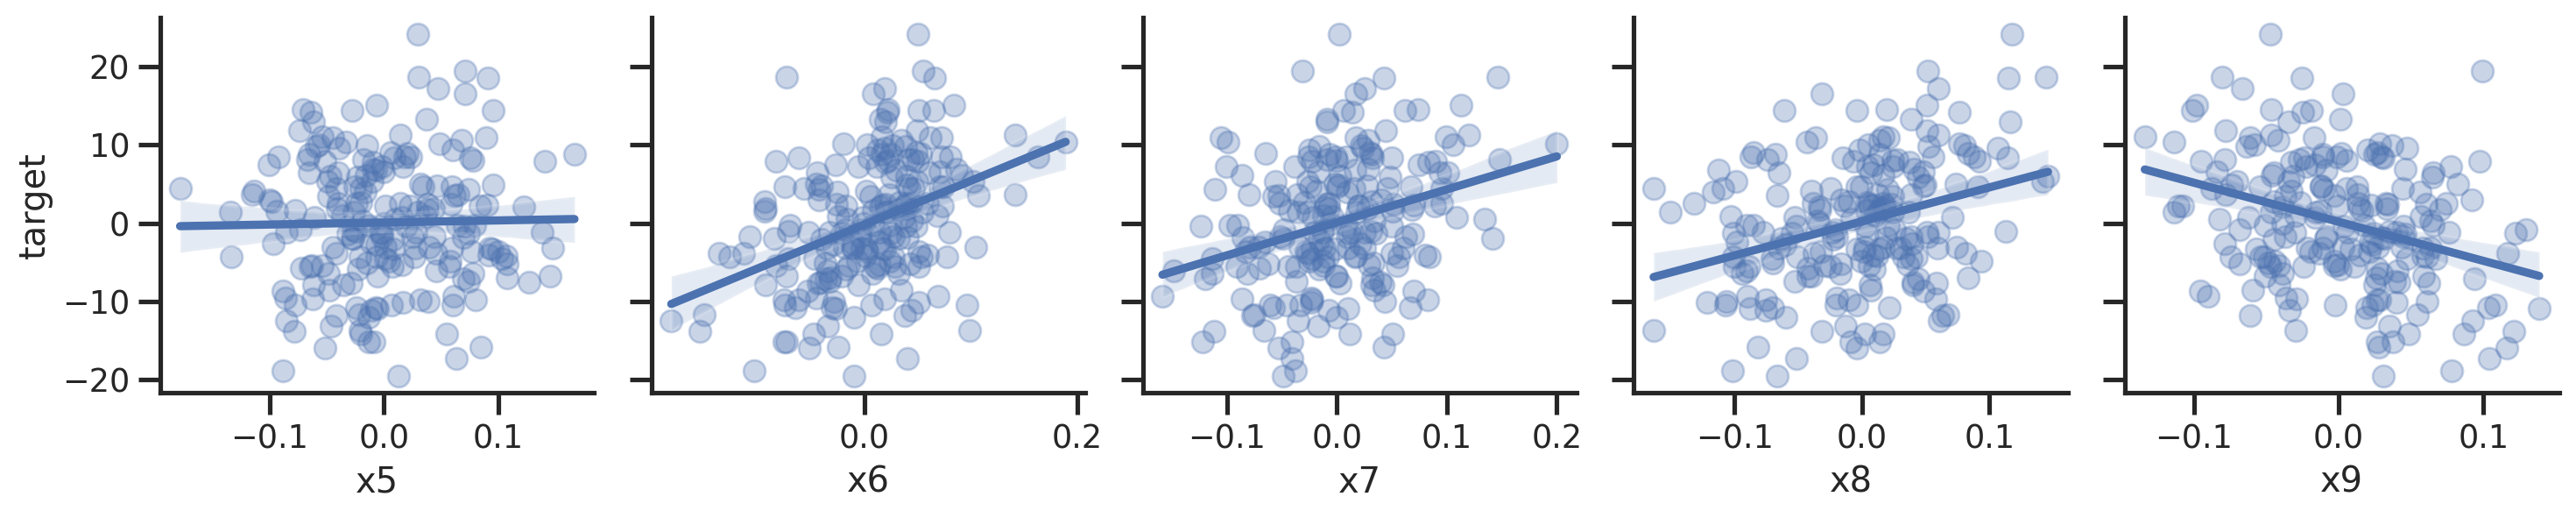

In [ ]:
sns.pairplot(
    data=data, x_vars=['x5','x6','x7','x8','x9'], y_vars='target',
    height=3, kind='reg', plot_kws=dict(scatter_kws=(dict(alpha=0.3)))
);

Which features would you exclude?

### Automated Feature Selection (AFS): Univariate

* Supervised, univariate, **relationship with target**
    - We've done it before manually and with the support of EDA
    - Bear in mind that it is univariate... if a feature is useful only for interactions, it won't be picked up
    - Most common case is `SelectKBest` with `f_regression` or `f_classif`

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
selector = SelectKBest(f_regression, k=4).fit(X, y)
X_sel = selector.transform(X)

In [ ]:
X_sel[0]

array([-0.0671294 , -0.05033075,  0.06467563, -0.02987498])

In [ ]:
selector.get_feature_names_out()

array(['x0', 'x1', 'x3', 'x6'], dtype=object)

In [ ]:
pd.DataFrame(X_sel, columns=selector.get_feature_names_out()).head()

,x0,x1,x3,x6
0,-0.067129,-0.050331,0.064676,-0.029875
1,0.024038,-0.151941,0.072388,0.141541
2,0.028244,0.006726,0.091272,0.065806
3,0.000540,0.111140,-0.042694,0.001695
4,0.019776,-0.038470,0.104961,0.043904


In [ ]:
# could create a pipeline simply to get a pandas DataFrame as output
selector = make_pipeline(
    SelectKBest(f_regression, k=7)
).set_output(transform='pandas').fit(X, y)
X_sel = selector.transform(X)

In [ ]:
X_sel.head()

,x0,x1,x3,x6,x7,x8,x9
0,-0.067129,-0.050331,0.064676,-0.029875,-0.057434,-0.070257,0.019514
1,0.024038,-0.151941,0.072388,0.141541,0.119834,0.059714,-0.046511
2,0.028244,0.006726,0.091272,0.065806,0.042542,0.114960,-0.025738
3,0.000540,0.111140,-0.042694,0.001695,-0.018666,-0.039486,-0.032984
4,0.019776,-0.038470,0.104961,0.043904,-0.052150,-0.131623,0.013012


In [ ]:
model = Ridge().fit(X_sel, y)
scores = cross_val_score(model, X_sel, y)
scores.mean(), scores.std()

(0.5225239834317664, 0.03463121132317368)

In [ ]:
model = Ridge().fit(X, y)
scores = cross_val_score(model, X, y)
scores.mean(), scores.std()

(0.5284461212357676, 0.032743510771575106)

### Recursive Feature Elimination (RFE)

- mindset: start with all, build the model, look at **feature importance** (e.g., `coef_`), remove the least important, repeat
- you will provide a $k$

We will go straight to `RFECV`, where the best $f$ is obtained for you based on cross-validation scores.

In [ ]:
from sklearn.feature_selection import RFECV

In [ ]:
model = Ridge()
ref_selector = RFECV(model, step=1, cv=5)

In [ ]:
ref_selector.fit(X, y)

RFECV(cv=5, estimator=Ridge())

In [ ]:
ref_selector.get_feature_names_out()

array(['x0', 'x1', 'x3', 'x4', 'x6', 'x7', 'x8', 'x9'], dtype=object)

In [ ]:
n_scores = len(ref_selector.cv_results_["mean_test_score"])
n_scores

10

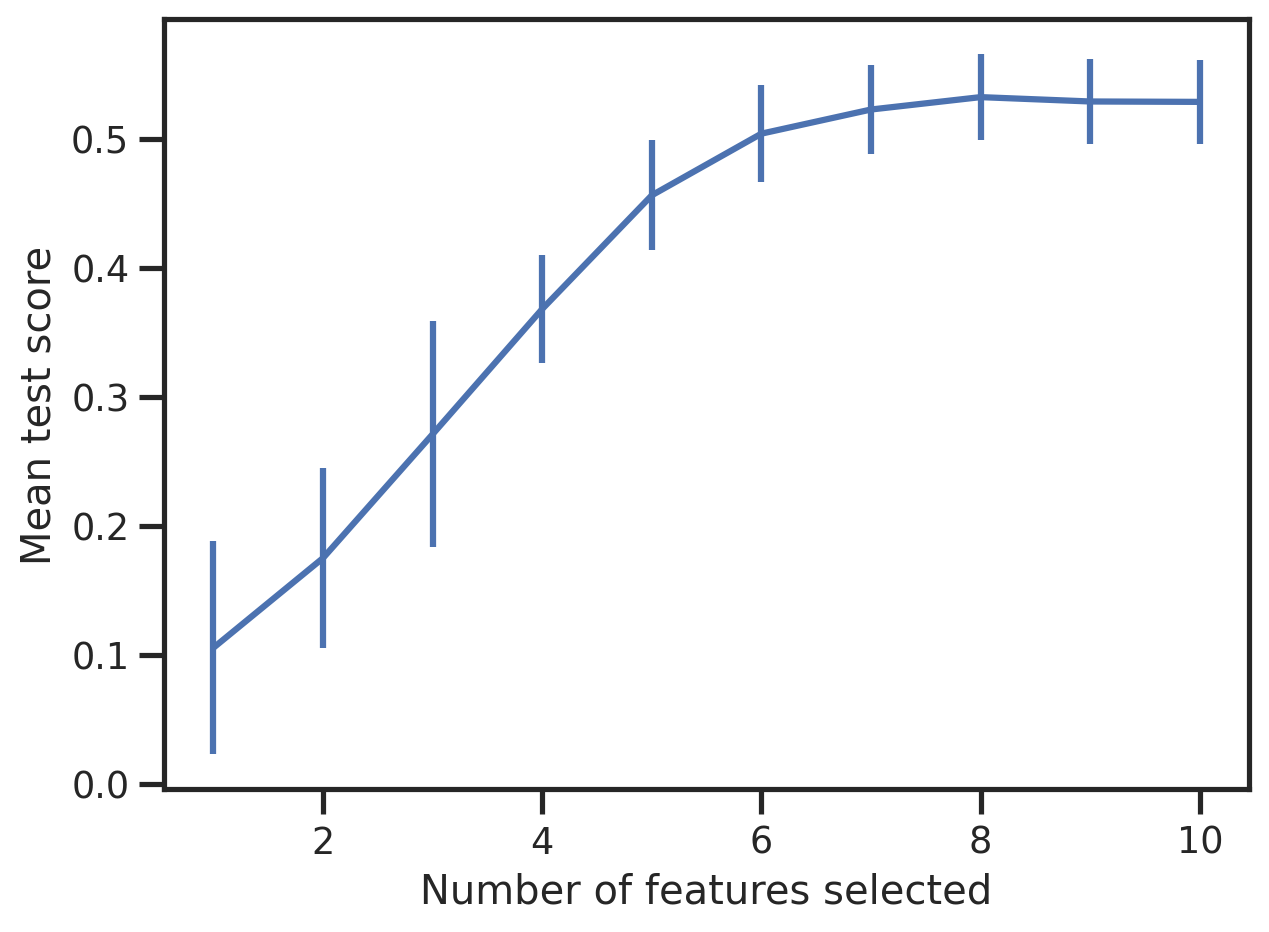

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(
    range(1, n_scores+1),
    ref_selector.cv_results_["mean_test_score"],
    yerr=ref_selector.cv_results_["std_test_score"],
)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test score");

### Sequential Feature Selection (SFS) (Forward/Backward)

- Greedy search
- Forward-SFS: "start with zero features and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached"
- difference from RFE: **model performance**

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
sfs_forward = SequentialFeatureSelector(
    Ridge(), n_features_to_select='auto', direction="forward"
).fit(X, y)

In [ ]:
sfs_forward.get_feature_names_out()

array(['x0', 'x1', 'x3', 'x6', 'x8'], dtype=object)

In [ ]:
dir(sfs_forward)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_get_best_new_feature_score',
 '_get_param_names',
 '_get_support_mask',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_sklearn_auto_wrap_output_keys',
 '_transform',
 '_validate_data',
 '_validate_params',
 'cv',
 'direction',
 'estimator',
 'feature_names_in_',
 'fit',
 'fit_transform',
 'get_feature_names_out',
 'get_params',
 'get_support',
 'inverse_transform',
 'n_features_in_',
 'n_f

In [ ]:
[ n for n in dir(sfs_forward) if n.endswith('_')]

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_repr_html_',
 '_repr_mimebundle_',
 'feature_names_in_',
 'n_features_in_',
 'n_features_to_select_',
 'support_']

## Case Study: Bike Rides with Polynomial/Interaction Features, Pipeline

### Dataset

In [ ]:
rides_full = pd.read_csv(
    'https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv'
)

In [ ]:
rides_full.head(1)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0


In [ ]:
rides_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           731 non-null    object 
 1   yr               731 non-null    int64  
 2   mnth             731 non-null    object 
 3   holiday          731 non-null    object 
 4   weekday          731 non-null    object 
 5   workingday       731 non-null    object 
 6   weathersit       731 non-null    object 
 7   temp             731 non-null    float64
 8   hum              731 non-null    float64
 9   windspeed        731 non-null    float64
 10  cnt              731 non-null    int64  
 11  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 68.7+ KB


In [ ]:
rides = rides_full[
    [ 'workingday', 'temp', 'hum', 'windspeed', 'days_since_2011', 'cnt' ]
].rename(columns=dict(days_since_2011='days_elapsed', cnt='rides_count'))

In [ ]:
rides.head()

,workingday,temp,hum,windspeed,days_elapsed,rides_count
0,NO WORKING DAY,8.175849,80.5833,10.749882,0,985
1,NO WORKING DAY,9.083466,69.6087,16.652113,1,801
2,WORKING DAY,1.229108,43.7273,16.636703,2,1349
3,WORKING DAY,1.400000,59.0435,10.739832,3,1562
4,WORKING DAY,2.666979,43.6957,12.522300,4,1600


In [ ]:
X, y = rides.drop(columns='rides_count'), rides['rides_count']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=0)

### Pre-Processing and Model Fitting Pipelines

In [ ]:
numeric_features = X_train.select_dtypes(exclude='object').columns.tolist()
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("poly_int", PolynomialFeatures(degree=2, include_bias=False))
    ]
).set_output(transform='pandas')
print(numeric_features)
numeric_transformer

['temp', 'hum', 'windspeed', 'days_elapsed']


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('poly_int', PolynomialFeatures(include_bias=False))])

In [ ]:
numeric_transformer.fit_transform(X_train[numeric_features]).head()

,temp,hum,windspeed,days_elapsed,temp^2,temp hum,temp windspeed,temp days_elapsed,hum^2,hum windspeed,hum days_elapsed,windspeed^2,windspeed days_elapsed,days_elapsed^2
452,-0.039260,-1.008306,1.313328,0.414193,0.001541,0.039586,-0.051562,-0.016261,1.016682,-1.324237,-0.417634,1.724830,0.543972,0.171556
337,-0.873856,1.115157,-1.373436,-0.127700,0.763625,-0.974487,1.200186,0.111592,1.243576,-1.531597,-0.142406,1.886327,0.175388,0.016307
509,0.890583,0.688667,-0.223027,0.682784,0.793137,0.613315,-0.198624,0.608076,0.474262,-0.153591,0.470211,0.049741,-0.152279,0.466194
77,-0.102764,-1.744159,2.302804,-1.352851,0.010560,0.179236,-0.236645,0.139024,3.042089,-4.016455,2.359586,5.302905,-3.115350,1.830205
451,-0.914679,-2.386907,-0.038108,0.409481,0.836637,2.183254,0.034857,-0.374544,5.697327,0.090961,-0.977394,0.001452,-0.015605,0.167675


In [ ]:
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')),
    ]
).set_output(transform='pandas')

In [ ]:
categorical_transformer.fit_transform(X_train[categorical_features]).head()

,workingday_WORKING DAY
452,1.0
337,0.0
509,1.0
77,0.0
451,1.0


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [ ]:
regr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # ("featsel", RFECV(model, step=1, cv=5)),
        ("featsel", SelectKBest(f_regression, k=10)),
        ("regr", Ridge(alpha=100))
    ]
).set_output(transform="pandas")

In [ ]:
regr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly_int',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['temp', 'hum', 'windspeed',
                                                   'days_elapsed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['workingday'])],
                                   verbose_feature_names_out=False)),
                ('featsel',
                 SelectKBest(score_func=<function f_regression at 0x7fd1888493a0>)),
                ('regr', Ridge(alpha=100))])

In [ ]:
regr_pipe['featsel'].get_feature_names_out()

array(['temp', 'windspeed', 'days_elapsed', 'temp^2', 'temp hum',
       'temp days_elapsed', 'hum^2', 'hum days_elapsed', 'windspeed^2',
       'days_elapsed^2'], dtype=object)

In [ ]:
regr_pipe['featsel'].transform(
    regr_pipe['preprocessor'].transform(X_train)
).head()

,temp,windspeed,days_elapsed,temp^2,temp hum,temp days_elapsed,hum^2,hum days_elapsed,windspeed^2,days_elapsed^2
452,-0.039260,1.313328,0.414193,0.001541,0.039586,-0.016261,1.016682,-0.417634,1.724830,0.171556
337,-0.873856,-1.373436,-0.127700,0.763625,-0.974487,0.111592,1.243576,-0.142406,1.886327,0.016307
509,0.890583,-0.223027,0.682784,0.793137,0.613315,0.608076,0.474262,0.470211,0.049741,0.466194
77,-0.102764,2.302804,-1.352851,0.010560,0.179236,0.139024,3.042089,2.359586,5.302905,1.830205
451,-0.914679,-0.038108,0.409481,0.836637,2.183254,-0.374544,5.697327,-0.977394,0.001452,0.167675


In [ ]:
regr_pipe.score(X_test, y_test)

0.7160165770113671

In [ ]:
rmse(y_test, regr_pipe.predict(X_test))

1122.0677271384816

In [ ]:
scores = cross_val_score(
    regr_pipe, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error'
)*-1
scores.mean(), scores.std()

(936.9229327361761, 120.35107951307972)